# Notebook magique with AutoML

TO DO:
- fix log
- remove outliers

See 
https://github.com/parklize/cikm2020-analyticup?fbclid=IwAR0Ti_pF7HrIO5ELFlvA1b2FEL_D68xlu_XdXeFxyARzBfY5U7a040klHTM

In [1]:
import csv
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sns as sns
from sklearn.metrics import mean_absolute_error
from verstack.stratified_continuous_split import scsplit # pip install verstack


# Load the training data
train_data = pd.read_csv("data/train.csv")

# Load the evaluation data
eval_data = pd.read_csv("data/evaluation.csv")





c:\Users\maria\anaconda3\lib\site-packages\xgboost\compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


Split data

In [2]:
#split data
X_train, X_test, y_train, y_test = scsplit(train_data, train_data['retweets_count'], stratify=train_data['retweets_count'], train_size=0.8, test_size=0.2)
# We remove the actual number of retweets from our features since it is the value that we are trying to predict
X_train = X_train.drop(['retweets_count'], axis=1)
X_test = X_test.drop(['retweets_count'], axis=1)

## Outliers

In [187]:
# remove outliers with quartile
def remove_outliers(df, col):
    q1 = df[col].quantile(0.25)
    q3 = df[col].quantile(0.75)
    iqr = q3 - q1
    df = df[(df[col] >= q1 - 5 * iqr) & (df[col] <= q3 + 5 * iqr)]
    return df


In [82]:
def feature_engineering(in_df):
    rs_df = in_df

    #mentions is always empty -> DROP Mention
    rs_df = rs_df.drop(['mentions'], axis=1)

    #add a column to data which counts url
    rs_df['url_count'] = rs_df['urls'].str.count('http')
    rs_df= rs_df.drop(['urls'], axis=1)
    #add a column to data which gives length of hashtags
    #TO DO
    #add columns to data which makes ratios
    rs_df['followers_friends'] = rs_df['followers_count'] / (rs_df['friends_count'].apply(lambda x: x+1))
    rs_df['favorites_followers'] = rs_df['favorites_count'] / (rs_df['followers_count'].apply(lambda x: x+1))
    rs_df['favorites_friends'] = rs_df['favorites_count'] / (rs_df['friends_count'].apply(lambda x: x+1))
    return rs_df



In [89]:
from datetime import datetime
def time_engineering(in_df):
    rs_df = in_df
    rs_df["hour"] = rs_df['timestamp'].apply(lambda t: (datetime.fromtimestamp(t//1000)).hour)
    rs_df["day"] = rs_df['timestamp'].apply(lambda t: (datetime.fromtimestamp(t//1000)).weekday())
    rs_df["we"] = rs_df['day'].apply(lambda t: int(t==5 or t==6))
    rs_df.drop(['timestamp'], axis=1)

    return rs_df

In [5]:
from textblob import TextBlob #pip install textblob-fr
from textblob_fr import PatternTagger, PatternAnalyzer
def text_engineering(in_df):
    rs_df = in_df
    #add columns related to sentiment analysis
    rs_df['polarity']=rs_df['text'].apply(lambda x: TextBlob(x, pos_tagger=PatternTagger(), analyzer=PatternAnalyzer()).sentiment[0])
    rs_df['subjectivity']=rs_df['text'].apply(lambda x: TextBlob(x, pos_tagger=PatternTagger(), analyzer=PatternAnalyzer()).sentiment[1])
    #drop the text column
    rs_df = rs_df.drop(['text'], axis=1)
 

    return rs_df

In [88]:
from sklearn.feature_extraction.text import CountVectorizer
from nltk.corpus import stopwords
def hashtags_engineering(in_df):
    rs_df = in_df
    #make a string of the list
    rs_df['hashtags']=rs_df['hashtags'].apply(lambda x: x.replace('[','').replace(']','').replace("'",''))
    vectorizer2 = CountVectorizer(max_features=20, stop_words=stopwords.words('french')) 
    hashtags = vectorizer2.fit_transform(rs_df['hashtags'])
    # show vocabulary
    pop=np.sum(hashtags.toarray(),axis=1)
    #pop to df
    pop=pd.DataFrame(pop,columns=['pop'])# popularity=number of popular hashtags
    #add pop to df
    rs_df['pop']=pop
    #set nan to 0
    rs_df['pop']=rs_df['pop'].fillna(0)

    #has hashtags or not
    rs_df['has_hashtags']=rs_df['hashtags'].apply(lambda x: 0 if x=='' else 1)




    #drop the hashtags column
    rs_df = rs_df.drop(['hashtags'], axis=1)
    return rs_df


## Scaler

In [192]:
def logtransformdrop(dataframe, cols):
    for col in cols:
        dataframe['log_' + col ] = dataframe[col].apply(lambda x: np.log10(int(x)+1))
    dataframe = dataframe.drop(cols,axis=1)
    return dataframe

## Data processing

In [86]:
col=['TweetID','followers_count','friends_count','favorites_count', 'statuses_count','verified', 'url_count','followers_friends', 'favorites_followers', 'favorites_friends', 'hour', 'day','we', 'polarity', 'subjectivity','pop','has_hashtags']

In [90]:
new_X_train=feature_engineering(X_train)
new_X_train=time_engineering(new_X_train)
new_X_train=text_engineering(new_X_train)
new_X_train=hashtags_engineering(new_X_train)
#new_X_train=logtransformdrop(X_train,['followers.count','friends_count','favorites_count','followers_count'])
new_X_train=new_X_train.reindex(columns=col)
new_X_train.head()



,TweetID,followers_count,friends_count,favorites_count,statuses_count,verified,url_count,followers_friends,favorites_followers,favorites_friends,hour,day,we,polarity,subjectivity,pop,has_hashtags
333543,245660,443,546,0,11379,0,0,0.809872,0.000000,0.000000,16,5,1,0.40,0.500000,0.0,0
68017,57288,667,748,5,30282,0,1,0.890521,0.007485,0.006676,8,2,0,0.00,0.000000,0.0,0
148900,914650,1198,1894,0,68291,0,0,0.632190,0.000000,0.000000,11,4,0,0.00,0.000000,0.0,0
293632,959103,799,705,0,22198,0,0,1.131728,0.000000,0.000000,12,4,0,-0.04,0.533333,0.0,0
101565,1138817,2664,2070,0,8404,0,0,1.286335,0.000000,0.000000,15,4,0,0.00,0.000000,0.0,0


## Flaml

In [92]:
from flaml import AutoML
automl = AutoML()

settings = {
    "time_budget": 200,  # total running time in seconds
    "metric": 'mae',  # can be: 'r2', 'rmse', 'mae', 'mse', 'accuracy', 'roc_auc', 'roc_auc_ovr',
                           # 'roc_auc_ovo', 'log_loss', 'mape', 'f1', 'ap', 'ndcg', 'micro_f1', 'macro_f1'
    "task": 'regression',  # task type
    'estimator_list':['rf'],   #['lgbm', 'rf', 'xgboost', 'extra_tree', 'xgb_limitdepth']
    "seed": 7654321,    # random seed
}

automl.fit(new_X_train.drop(['TweetID','verified', 'url_count', 'pop', 'statuses_count'], axis=1), y_train, **settings)
# Print the best model
print(automl.model.estimator)

[flaml.automl: 11-22 12:08:39] {2600} INFO - task = regression
[flaml.automl: 11-22 12:08:39] {2602} INFO - Data split method: uniform
[flaml.automl: 11-22 12:08:39] {2605} INFO - Evaluation method: holdout
[flaml.automl: 11-22 12:08:39] {2727} INFO - Minimizing error metric: mae
[flaml.automl: 11-22 12:08:39] {2869} INFO - List of ML learners in AutoML Run: ['rf']
[flaml.automl: 11-22 12:08:39] {3164} INFO - iteration 0, current learner rf
[flaml.automl: 11-22 12:08:39] {3297} INFO - Estimated sufficient time budget=28037s. Estimated necessary time budget=28s.
[flaml.automl: 11-22 12:08:39] {3344} INFO -  at 1.5s,	estimator rf's best error=12.8057,	best estimator rf's best error=12.8057
[flaml.automl: 11-22 12:08:39] {3164} INFO - iteration 1, current learner rf
[flaml.automl: 11-22 12:08:39] {3344} INFO -  at 1.6s,	estimator rf's best error=12.8057,	best estimator rf's best error=12.8057
[flaml.automl: 11-22 12:08:39] {3164} INFO - iteration 2, current learner rf
[flaml.automl: 11-22

RandomForestRegressor(max_features=0.6784883486716243, max_leaf_nodes=4708,
                      n_estimators=82, n_jobs=-1)


In [196]:
print(automl.model.estimator)

RandomForestRegressor(max_features=0.9880212306377765, max_leaf_nodes=17416,
                      n_estimators=109, n_jobs=-1)



AutoML.fit(self, X_train, y_train, dataframe, label, metric, task, n_jobs, log_file_name, estimator_list, time_budget, max_iter, sample, ensemble, eval_method, log_type, model_history, split_ratio, n_splits, log_training_metric, mem_thres, pred_time_limit, train_time_limit, X_val, y_val, sample_weight_val, groups_val, groups, verbose, retrain_full, split_type, learner_selector, hpo_method, starting_points, seed, n_concurrent_trials, keep_search_state, preserve_checkpoint, early_stop, append_log, auto_augment, min_sample_size, use_ray, metric_constraints, custom_hp, cv_score_agg_func, skip_transform, fit_kwargs_by_estimator, **fit_kwargs)


xgboost, rf, lgbm, extra_tree

# Submission

In [77]:
#test on X_test
new_X_test=feature_engineering(X_test)
new_X_test=time_engineering(new_X_test)
new_X_test=text_engineering(new_X_test)
new_X_test=hashtags_engineering(new_X_test)
#new_X_train=logtransformdrop(X_train,['followers.count','friends_count','favorites_count','followers_count'])
new_X_test=new_X_test.reindex(columns=col)
new_X_test.head()


,TweetID,followers_count,friends_count,favorites_count,statuses_count,verified,url_count,followers_friends,favorites_followers,favorites_friends,hour,day,polarity,subjectivity,pop
40583,807745,683,671,0,4013,0,0,1.016369,0.000000,0.000000,10,6,0.000,0.000,0.0
147514,431422,563,851,4,3420,0,1,0.660798,0.007092,0.004695,13,3,0.085,0.000,0.0
185397,583903,6107,4944,31,53026,0,1,1.234985,0.005075,0.006269,13,2,-0.050,0.325,0.0
35111,931322,527,1547,0,4199,0,0,0.340439,0.000000,0.000000,10,4,0.000,0.000,2.0
52476,1085116,583,655,0,17652,0,0,0.888720,0.000000,0.000000,21,0,0.000,0.000,0.0


In [78]:
from sklearn.neural_network import MLPRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
model=RandomForestRegressor(max_features=0.9510381925366853, max_leaf_nodes=123,
                      n_estimators=4, n_jobs=-1)
model.fit(new_X_train.drop(['TweetID','verified', 'url_count', 'pop', 'statuses_count'],axis=1), y_train)
y_pred = model.predict(new_X_test.drop(['TweetID','verified', 'url_count', 'followers_friends', 'statuses_count'],axis=1))
print(mean_absolute_error(y_test, y_pred))

8.015422205686958


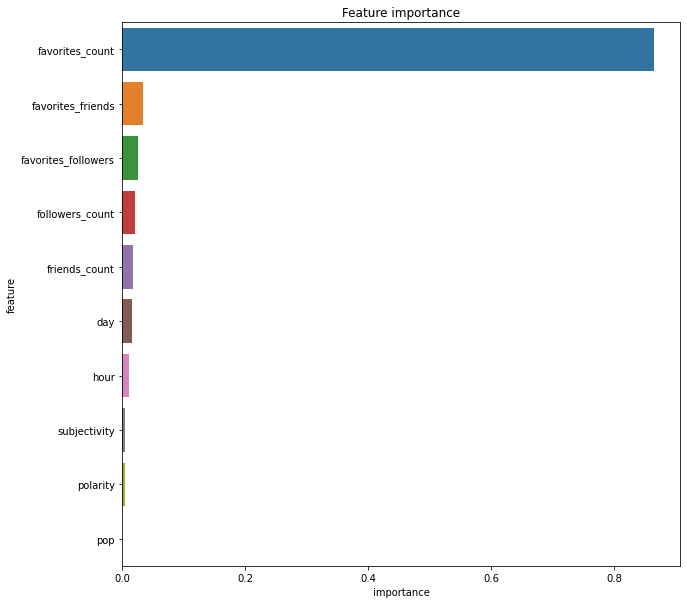

<AxesSubplot:>

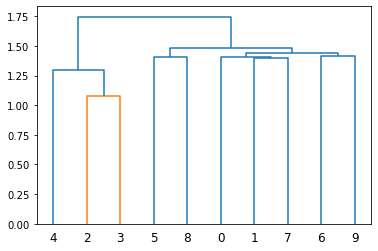

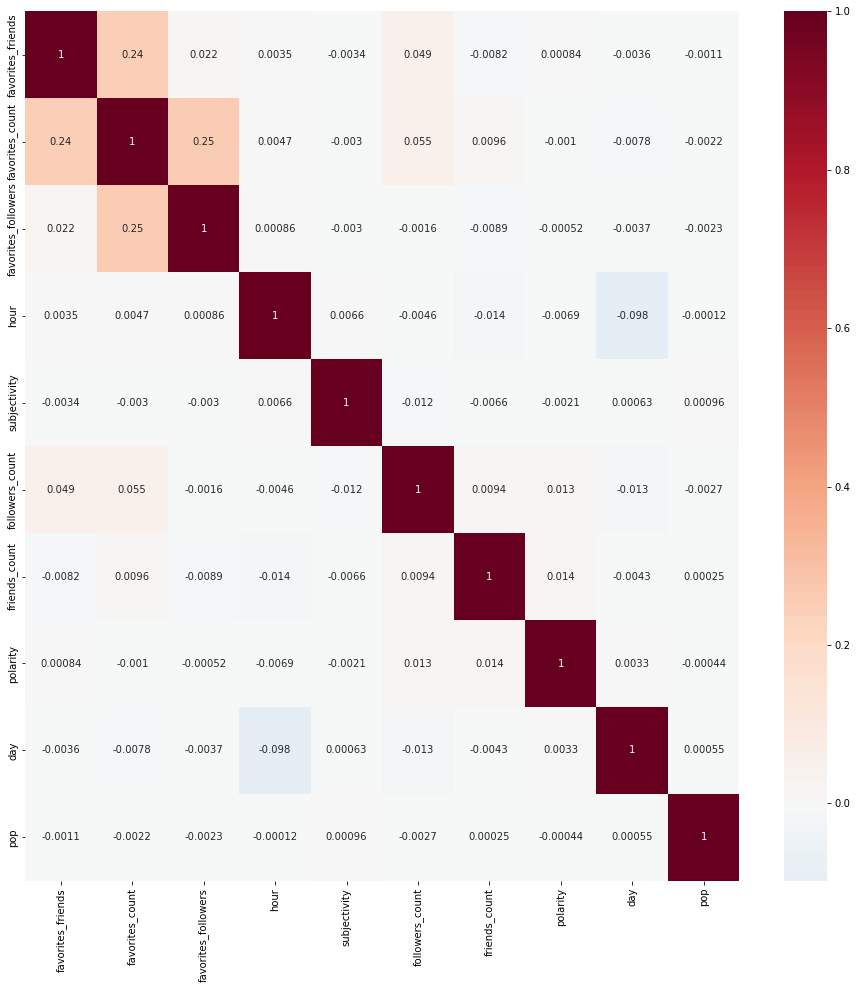

In [79]:
#plot feature importance
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
feature_importance = pd.DataFrame({'feature': new_X_train.drop(['TweetID','verified', 'url_count', 'pop', 'statuses_count'],axis=1).columns, 'importance': model.feature_importances_})
plt.figure(figsize=(10, 10))
sns.barplot(data=feature_importance.sort_values(by='importance', ascending=False), x='importance', y='feature')
plt.title('Feature importance')
plt.show()


# plot correlation of features
from scipy.cluster import hierarchy
import seaborn as sbn

order = np.array(hierarchy.dendrogram(
    hierarchy.ward(new_X_train.drop(['TweetID','verified', 'url_count', 'pop', 'statuses_count'],axis=1).corr()),no_plot=False)['ivl'], dtype="int")

rearranged_cov = new_X_train.drop(['TweetID','verified', 'url_count', 'pop', 'statuses_count'],axis=1).corr().iloc[order, order]

plt.figure(figsize=(16, 16))

sbn.heatmap(rearranged_cov, annot=True, cmap="RdBu_r", center=0)

